Minimizing overfitting using Twitter US Airline Sentiment Analysis Kaggle Dataset

In [26]:
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path
#Data prep packages
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
#model architecture
from keras import models
from keras import layers
from keras import regularizers
NB_WORDS = 10000  #number of words
NB_START_EPOCHS = 20 #train using 20 epochs
BATCH_SIZE = 512
MAX_LEN = 20  #max number of words in sequence
root = Path('../')
input_path = root / 'input/' 
ouput_path = root / 'output/'
source_path = root / 'source/'

In [10]:
# Helper functions

def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Defines the optimizer, loss, and metric. Trains the model
    @params: X input (train), Y target (train), X input (validation), Y target (val)
    Output: accuracy and loss
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=2)
    return history
def eval_metric(model, history, metric_name):
    '''
    Plot training and validation loss and accuracy
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    e = range(1, NB_START_EPOCHS + 1)
    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    plt.show()
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Test the model on the new data (testing set) after it's trained.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    print()
    print('Test accuracy: {0:.2f}%'.format(results[1]*100))
    return results
    
def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    '''
    Remove @ Twitter mentions - irrelevant
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)
def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
    '''
    Function to compare a metric between two models 
        
    Output:
        plot of metrics of both models
    '''
    metric_model_1 = model_hist_1.history[metric]
    metric_model_2 = model_hist_2.history[metric]
    e = range(1, NB_START_EPOCHS + 1)
    
    metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss'
    }
    
    metric_label = metrics_dict[metric]
    plt.plot(e, metric_model_1, 'bo', label=model_1.name)
    plt.plot(e, metric_model_2, 'b', label=model_2.name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_label)
    plt.title('Comparing ' + metric_label + ' between models')
    plt.legend()
    plt.show()
    
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum - can use this in early stopping to prevent overfitting
    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

In [8]:
#Load dataset
from google.colab import drive
drive.mount("/content/gdrive")

df = pd.read_csv("/content/gdrive/MyDrive/Airline Sentiments/Tweets.csv")
df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [12]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))


#shuffle data for even distribution
df = df.reindex(np.random.permutation(df.index))  
#remove stopwords and mentions
df = df[['text', 'airline_sentiment']]
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)

In [14]:
#Use tokenizer to convert words to computer-readable numbers, convert to lowercase
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n',
               lower=True,
               char_level=False,
               split=' ')
tk.fit_on_texts(X_train)

In [15]:
#convert words to a vector using NB_WORDS

X_train_oh = tk.texts_to_matrix(X_train, mode='binary')
X_test_oh = tk.texts_to_matrix(X_test, mode='binary')


In [16]:
#One hot encoding - convert labels to numbers with to_categorical
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)


In [17]:
#split training set to get the validation set
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

In [23]:
#create an overfitted model

base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))


Epoch 1/20
24/24 - 2s - loss: 0.0348 - accuracy: 0.9894 - val_loss: 1.7370 - val_accuracy: 0.7534
Epoch 2/20
24/24 - 1s - loss: 0.0270 - accuracy: 0.9917 - val_loss: 1.8021 - val_accuracy: 0.7436
Epoch 3/20
24/24 - 1s - loss: 0.0254 - accuracy: 0.9917 - val_loss: 1.8614 - val_accuracy: 0.7527
Epoch 4/20
24/24 - 1s - loss: 0.0237 - accuracy: 0.9918 - val_loss: 1.9711 - val_accuracy: 0.7382
Epoch 5/20
24/24 - 1s - loss: 0.0226 - accuracy: 0.9926 - val_loss: 2.0071 - val_accuracy: 0.7420
Epoch 6/20
24/24 - 1s - loss: 0.0208 - accuracy: 0.9930 - val_loss: 2.0547 - val_accuracy: 0.7382
Epoch 7/20
24/24 - 1s - loss: 0.0200 - accuracy: 0.9930 - val_loss: 2.1309 - val_accuracy: 0.7367
Epoch 8/20
24/24 - 1s - loss: 0.0192 - accuracy: 0.9933 - val_loss: 2.1771 - val_accuracy: 0.7352
Epoch 9/20
24/24 - 1s - loss: 0.0189 - accuracy: 0.9933 - val_loss: 2.2375 - val_accuracy: 0.7398
Epoch 10/20
24/24 - 1s - loss: 0.0179 - accuracy: 0.9942 - val_loss: 2.3197 - val_accuracy: 0.7337
Epoch 11/20
24/24 -

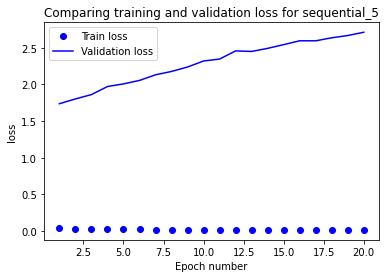

In [27]:
#plot the training vs validation
base_history = deep_model(base_model, X_train_rest, y_train_rest, X_valid, y_valid)
base_min = optimal_epoch(base_history)
eval_metric(base_model, base_history, 'loss')

#model is clearly overfitted because it's memorizing training data

3 ways to minimize overfitting:
1. Reduce network capacity by reducing layers
2. Regularization - drop excessively large weights
3. Dropout - remove certain features

Epoch 1/20
24/24 - 1s - loss: 0.9398 - accuracy: 0.6235 - val_loss: 0.8486 - val_accuracy: 0.6222
Epoch 2/20
24/24 - 1s - loss: 0.7795 - accuracy: 0.6456 - val_loss: 0.7605 - val_accuracy: 0.6480
Epoch 3/20
24/24 - 1s - loss: 0.6909 - accuracy: 0.6915 - val_loss: 0.7028 - val_accuracy: 0.7011
Epoch 4/20
24/24 - 1s - loss: 0.6213 - accuracy: 0.7427 - val_loss: 0.6574 - val_accuracy: 0.7390
Epoch 5/20
24/24 - 1s - loss: 0.5638 - accuracy: 0.7915 - val_loss: 0.6218 - val_accuracy: 0.7527
Epoch 6/20
24/24 - 0s - loss: 0.5149 - accuracy: 0.8229 - val_loss: 0.5919 - val_accuracy: 0.7747
Epoch 7/20
24/24 - 1s - loss: 0.4726 - accuracy: 0.8461 - val_loss: 0.5694 - val_accuracy: 0.7822
Epoch 8/20
24/24 - 1s - loss: 0.4362 - accuracy: 0.8630 - val_loss: 0.5539 - val_accuracy: 0.7815
Epoch 9/20
24/24 - 1s - loss: 0.4048 - accuracy: 0.8732 - val_loss: 0.5402 - val_accuracy: 0.7959
Epoch 10/20
24/24 - 1s - loss: 0.3778 - accuracy: 0.8821 - val_loss: 0.5311 - val_accuracy: 0.7951
Epoch 11/20
24/24 -

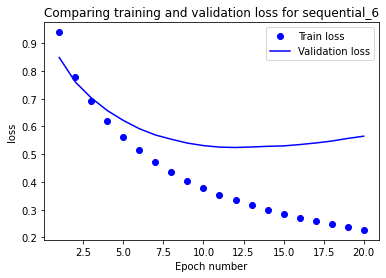

In [28]:
#Reduce network capacity

#create new model
reduced_model = models.Sequential()
#add dense layer
reduced_model.add(layers.Dense(16, activation='relu', input_shape=(NB_WORDS,)))
#add output layer
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_history = deep_model(reduced_model, X_train_rest, y_train_rest, X_valid, y_valid)
reduced_min = optimal_epoch(reduced_history)
#plot loss
eval_metric(reduced_model, reduced_history, 'loss')

Epoch 1/20
24/24 - 2s - loss: 0.9433 - accuracy: 0.6233 - val_loss: 0.7767 - val_accuracy: 0.7071
Epoch 2/20
24/24 - 1s - loss: 0.6667 - accuracy: 0.7727 - val_loss: 0.6521 - val_accuracy: 0.7883
Epoch 3/20
24/24 - 1s - loss: 0.5455 - accuracy: 0.8426 - val_loss: 0.6321 - val_accuracy: 0.7853
Epoch 4/20
24/24 - 1s - loss: 0.4822 - accuracy: 0.8638 - val_loss: 0.6187 - val_accuracy: 0.7906
Epoch 5/20
24/24 - 1s - loss: 0.4422 - accuracy: 0.8813 - val_loss: 0.6489 - val_accuracy: 0.7868
Epoch 6/20
24/24 - 1s - loss: 0.4130 - accuracy: 0.8904 - val_loss: 0.6517 - val_accuracy: 0.7959
Epoch 7/20
24/24 - 1s - loss: 0.3905 - accuracy: 0.8991 - val_loss: 0.6619 - val_accuracy: 0.7792
Epoch 8/20
24/24 - 1s - loss: 0.3692 - accuracy: 0.9097 - val_loss: 0.6725 - val_accuracy: 0.7876
Epoch 9/20
24/24 - 1s - loss: 0.3521 - accuracy: 0.9165 - val_loss: 0.7015 - val_accuracy: 0.7800
Epoch 10/20
24/24 - 1s - loss: 0.3375 - accuracy: 0.9212 - val_loss: 0.7371 - val_accuracy: 0.7663
Epoch 11/20
24/24 -

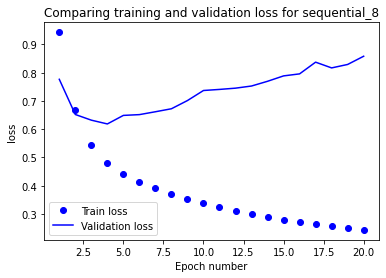

In [30]:
#Apply regularizer
''' Using L2 regularizer because it reduces coefficients evenly and simplifies model '''
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_history = deep_model(reg_model, X_train_rest, y_train_rest, X_valid, y_valid)
reg_min = optimal_epoch(reg_history)
eval_metric(reg_model, reg_history, 'loss')
#starts overfitting same time sa baseline, but loss is lower

Epoch 1/20
24/24 - 2s - loss: 0.8998 - accuracy: 0.6064 - val_loss: 0.7734 - val_accuracy: 0.6138
Epoch 2/20
24/24 - 1s - loss: 0.7164 - accuracy: 0.6641 - val_loss: 0.6718 - val_accuracy: 0.7231
Epoch 3/20
24/24 - 1s - loss: 0.6024 - accuracy: 0.7640 - val_loss: 0.5948 - val_accuracy: 0.7754
Epoch 4/20
24/24 - 1s - loss: 0.5196 - accuracy: 0.8111 - val_loss: 0.5545 - val_accuracy: 0.7906
Epoch 5/20
24/24 - 1s - loss: 0.4573 - accuracy: 0.8343 - val_loss: 0.5426 - val_accuracy: 0.7860
Epoch 6/20
24/24 - 1s - loss: 0.4079 - accuracy: 0.8560 - val_loss: 0.5409 - val_accuracy: 0.7891
Epoch 7/20
24/24 - 1s - loss: 0.3645 - accuracy: 0.8722 - val_loss: 0.5526 - val_accuracy: 0.7906
Epoch 8/20
24/24 - 1s - loss: 0.3359 - accuracy: 0.8829 - val_loss: 0.5605 - val_accuracy: 0.7944
Epoch 9/20
24/24 - 1s - loss: 0.3005 - accuracy: 0.8936 - val_loss: 0.5877 - val_accuracy: 0.7914
Epoch 10/20
24/24 - 1s - loss: 0.2780 - accuracy: 0.9006 - val_loss: 0.5988 - val_accuracy: 0.7891
Epoch 11/20
24/24 -

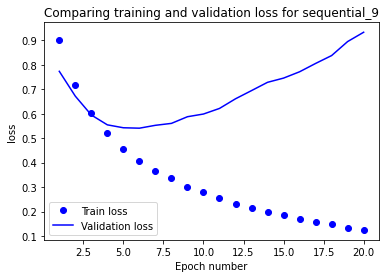

In [31]:
#Add dropout layers

#create new model
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
#sets inputs to 0 at a rate of 0.5 during training
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_history = deep_model(drop_model, X_train_rest, y_train_rest, X_valid, y_valid)
drop_min = optimal_epoch(drop_history)
#plot loss
eval_metric(drop_model, drop_history, 'loss')


In [32]:
#Utilize full training and test data

#combining the base model, reduced layers, regularized model, and dropout layer model to increase test accuracy
base_results = test_model(base_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, base_min)
reduced_results = test_model(reduced_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reduced_min)
reg_results = test_model(reg_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reg_min)
drop_results = test_model(drop_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, drop_min)

#End test accuracy: 80.33%

46/46 [==============================] - 0s 2ms/step - loss: 1.5519 - accuracy: 0.7760

Test accuracy: 77.60%
46/46 [==============================] - 0s 2ms/step - loss: 0.5755 - accuracy: 0.7992

Test accuracy: 79.92%
46/46 [==============================] - 0s 3ms/step - loss: 0.6965 - accuracy: 0.7992

Test accuracy: 79.92%
46/46 [==============================] - 0s 2ms/step - loss: 0.7668 - accuracy: 0.8033

Test accuracy: 80.33%
